In [9]:
from mcbj import *
import plots
import filter_traces

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, StrMethodFormatter
import numpy as np
# import pandas as pd

In [2]:
date = "23_07_10"
home_folder = Path(f'//DATACENTER/BreakJunction_group/BJ_Data/{date}')

In [3]:
hist = Histogram(folder=home_folder,
                 start_trace=15000, end_trace=16000,
                 conductance_range=(1e-5, 10),
                 conductance_log_scale=True,
                 conductance_bins_num=100,
                 conductance_bins_mode='total')

hist.calc_stats(align_at=0.5, interpolate=True,
                range_pull=(-0.5, 1),
                range_push=(-0.5, 1.5))

  0%|          | 0/1001 [00:00<?, ?it/s]

Pull 2D histogram created from 1001 traces
Push 2D histogram created from 1001 traces


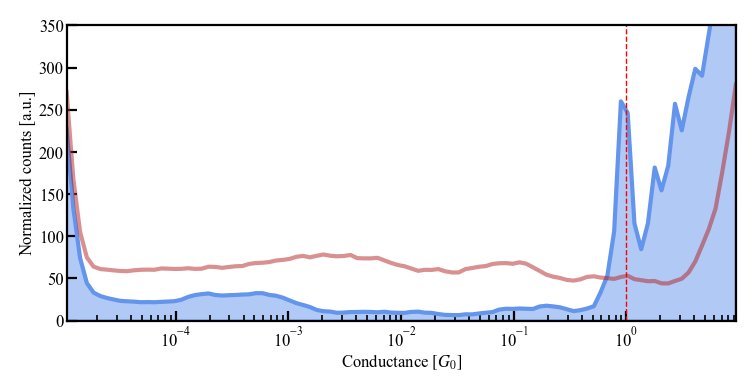

In [4]:
ax = hist.plot_hist_1d(dpi=200)
ax.set_ylim(0, 350)
ax.axvline(1, ls='--', lw=0.5, c='r')

In [5]:
hist = Histogram(folder=home_folder,
                 start_trace=24001, end_trace=26530,
                 conductance_range=(1e-5, 10),
                 conductance_log_scale=True,
                 conductance_bins_num=100,
                 conductance_bins_mode='total')

hist.calc_stats(align_at=0.5, interpolate=True,
                range_pull=(-0.5, 1),
                range_push=(-0.5, 1.5))

  0%|          | 0/2530 [00:00<?, ?it/s]

Pull 2D histogram created from 2530 traces
Push 2D histogram created from 2530 traces


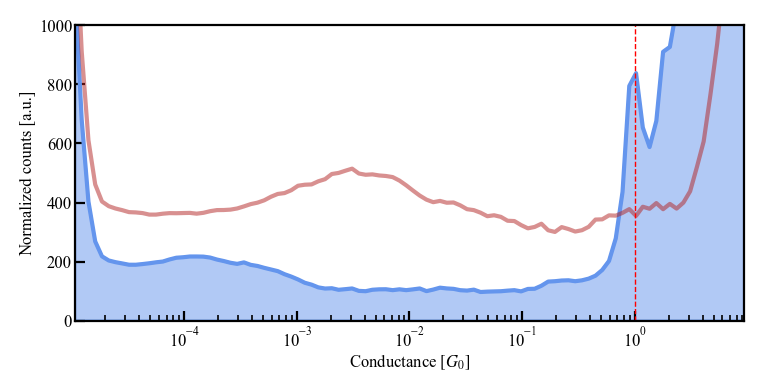

In [6]:
ax = hist.plot_hist_1d(dpi=200)
ax.set_ylim(0, 1000)
ax.axvline(1, ls='--', lw=0.5, c='r')

### Filtering traces that did not break during the hold measurement

In [7]:
total_num = 28871-16001+1
print(total_num)

12871


In [13]:
# did_not_break_pull, did_not_break_push = filter_traces.filter_hold(home_folder,
#                                                                    filter_condition=filter_traces.does_not_break_array,
#                                                                    start_trace=16001, end_trace=28871,
#                                                                    bias_offset=0, r_serial_ohm=100_300,
#                                                                    min_step_len=20_000)
# with open(home_folder.joinpath('results/did_not_break_pull.npy'), 'wb') as f:
#     np.save(f, did_not_break_pull)
    
# with open(home_folder.joinpath('results/did_not_break_push.npy'), 'wb') as f:
#     np.save(f, did_not_break_push)

In [14]:
with open(home_folder.joinpath('results/did_not_break_pull.npy'), 'rb') as f:
    did_not_break_pull = np.load(f)
    
with open(home_folder.joinpath('results/did_not_break_push.npy'), 'rb') as f:
    did_not_break_push = np.load(f)

In [15]:
print(f'pull: {len(did_not_break_pull)}, {len(did_not_break_pull)/total_num*100}%')
print(f'push: {len(did_not_break_push)}, {len(did_not_break_push)/total_num*100}%')

pull: 6940, 53.91966436174346%
push: 10280, 79.86947401134333%


### Filtering traces where the conductance on the two 200 mV bias plateaus do not differ more than a factor of 2

In [16]:
stable_pull, _ = filter_traces.filter_hold(home_folder, filter_condition=filter_traces.conductances_close,
                                           traces=did_not_break_pull,
                                           bias_offset=0, r_serial_ohm=100_300,
                                           min_step_len=20_000, max_ratio=2, plateaus=(0, -1))

_, stable_push = filter_traces.filter_hold(home_folder, filter_condition=filter_traces.conductances_close,
                                           traces=did_not_break_push,
                                           bias_offset=0, r_serial_ohm=100_300,
                                           min_step_len=20_000, max_ratio=2, plateaus=(0, -1))

with open(home_folder.joinpath('results/stable_pull.npy'), 'wb') as f:
    np.save(f, stable_pull)
    
with open(home_folder.joinpath('results/stable_push.npy'), 'wb') as f:
    np.save(f, stable_push)

  0%|          | 0/6940 [00:00<?, ?it/s]

  0%|          | 0/10280 [00:00<?, ?it/s]

In [17]:
with open(home_folder.joinpath('results/stable_pull.npy'), 'rb') as f:
    stable_pull = np.load(f)
    
with open(home_folder.joinpath('results/stable_push.npy'), 'rb') as f:
    stable_push = np.load(f)

In [18]:
print(f'pull: {len(stable_pull)}, {len(stable_pull)/total_num*100}%')
print(f'push: {len(stable_push)}, {len(stable_push)/total_num*100}%')

pull: 6940, 53.91966436174346%
push: 10280, 79.86947401134333%


### Filtering traces with nice I(V)s

We are interested in the I(V) curves where the up-down sweeps overlap nicely. The difference between the up-down sweeps is calculated with the function `filter_traces.iv_difference`

In [19]:
def get_iv_diff(trace: int, direction: str):
    try:
        hold_trace = HoldTrace(trace, load_from=home_folder, bias_offset=0,
                               r_serial_ohm=100_300, min_step_len=5_000, min_height=1, iv=0)
        # push_diff.append(filter_traces.iv_difference(hold_trace, direction='push', smoothing=100))
        # traces.append(hold_trace.trace_num)
        return filter_traces.iv_difference(hold_trace, direction=direction, smoothing=100)
    except MeasurementOverflow:
        return -1

In [20]:
push_diff = np.array(list(map(get_iv_diff, stable_push, ['push']*len(stable_push))))

D:\mcbj_stmbj\mcbj.py:2384: MeasurementOverflow: Current overflow during I(V) cycle, in pull direction.
  warnings.warn('Current overflow during I(V) cycle, in pull direction.', MeasurementOverflow)
D:\mcbj_stmbj\mcbj.py:2387: MeasurementOverflow: Current overflow during I(V) cycle, in push direction.
  warnings.warn('Current overflow during I(V) cycle, in push direction.', MeasurementOverflow)


In [21]:
pull_diff = np.array(list(map(get_iv_diff, stable_pull, ['pull']*len(stable_pull))))

1473 14.328793774319065


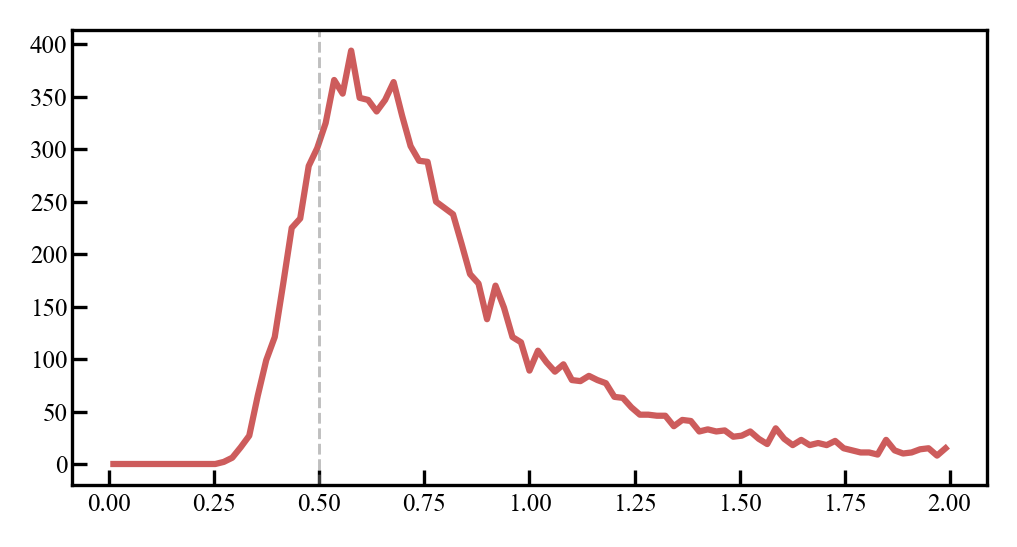

In [22]:
push_diff_bins, push_diff_hist = utils.calc_hist_1d_single(data=push_diff, xrange=(0, 2),
                                                           xbins_num=100, log_scale=False)

print(len(push_diff[push_diff < 0.5]), len(push_diff[push_diff < 0.5])/len(push_diff)*100)

fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 5), dpi=300)
ax.plot(push_diff_bins, push_diff_hist, 'indianred')
ax.axvline(0.5, c='grey', alpha=0.5, ls='--', lw=0.7)

256 3.688760806916427


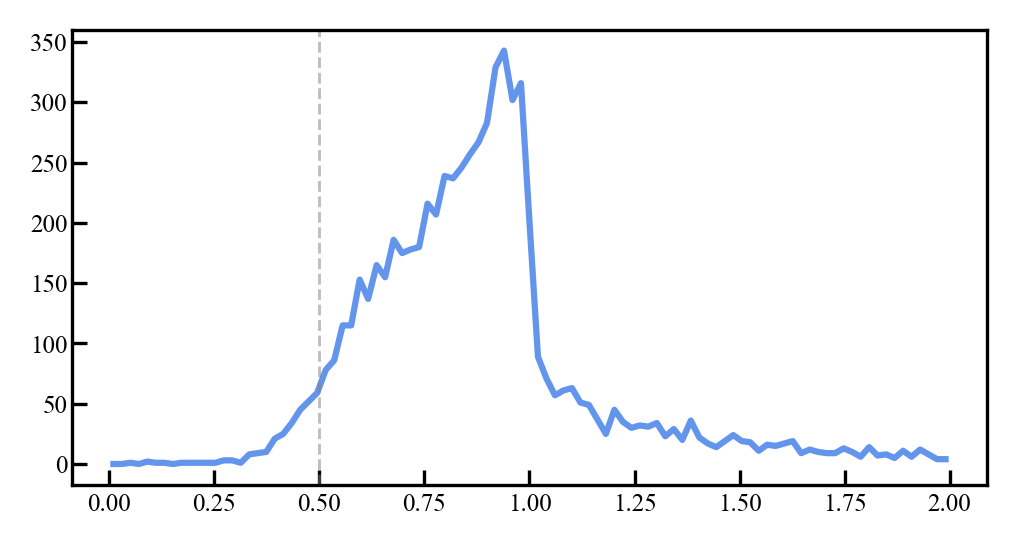

In [23]:
pull_diff_bins, pull_diff_hist = utils.calc_hist_1d_single(data=pull_diff, xrange=(0, 2),
                                                           xbins_num=100, log_scale=False)

print(len(pull_diff[pull_diff < 0.5]), len(pull_diff[pull_diff < 0.5])/len(pull_diff)*100)

fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 5), dpi=300)
ax.plot(pull_diff_bins, pull_diff_hist, 'cornflowerblue')
ax.axvline(0.5, c='grey', alpha=0.5, ls='--', lw=0.7)

In [24]:
# iv_good_push = stable_push[np.where(np.logical_and(push_diff > 0, push_diff < 0.5))[0]]
# iv_good_pull = stable_pull[np.where(np.logical_and(pull_diff > 0, pull_diff < 0.5))[0]]

# with open(home_folder.joinpath('results/iv_good_pull.npy'), 'wb') as f:
#     np.save(f, iv_good_pull)
    
# with open(home_folder.joinpath('results/iv_good_push.npy'), 'wb') as f:
#     np.save(f, iv_good_push)

In [25]:
with open(home_folder.joinpath('results/iv_good_pull.npy'), 'rb') as f:
    iv_good_pull = np.load(f)
    
with open(home_folder.joinpath('results/iv_good_push.npy'), 'rb') as f:
    iv_good_push = np.load(f)

In [27]:
print(f'pull: {len(iv_good_pull)}, {len(iv_good_pull)/total_num*100}%')
print(f'push: {len(iv_good_push)}, {len(iv_good_push)/total_num*100}%')

pull: 256, 1.988967446196877%
push: 1473, 11.444332219718747%


In [3]:
# filtered_push_diff = push_diff[push_diff < 0.5]
# filtered_pull_diff = pull_diff[pull_diff < 0.5]
# print(iv_good_push[np.argsort(filtered_push_diff)])
# print(filtered_push_diff[np.argsort(filtered_push_diff)])

### Filtering traces where the up-down I(V) sweeps overlap

In [30]:
my_colors = np.vstack((colormaps['inferno'](np.linspace(0.2, 1, 5)[0]),
                       np.array([[0, 0, 0, 1]]),
                       colormaps['inferno'](np.linspace(0.2, 1, 5)),
                       colormaps['inferno'](np.linspace(0.2, 1, 5))[-2::-1]))

Text(0.5, 0.98, 'Trace 28871')

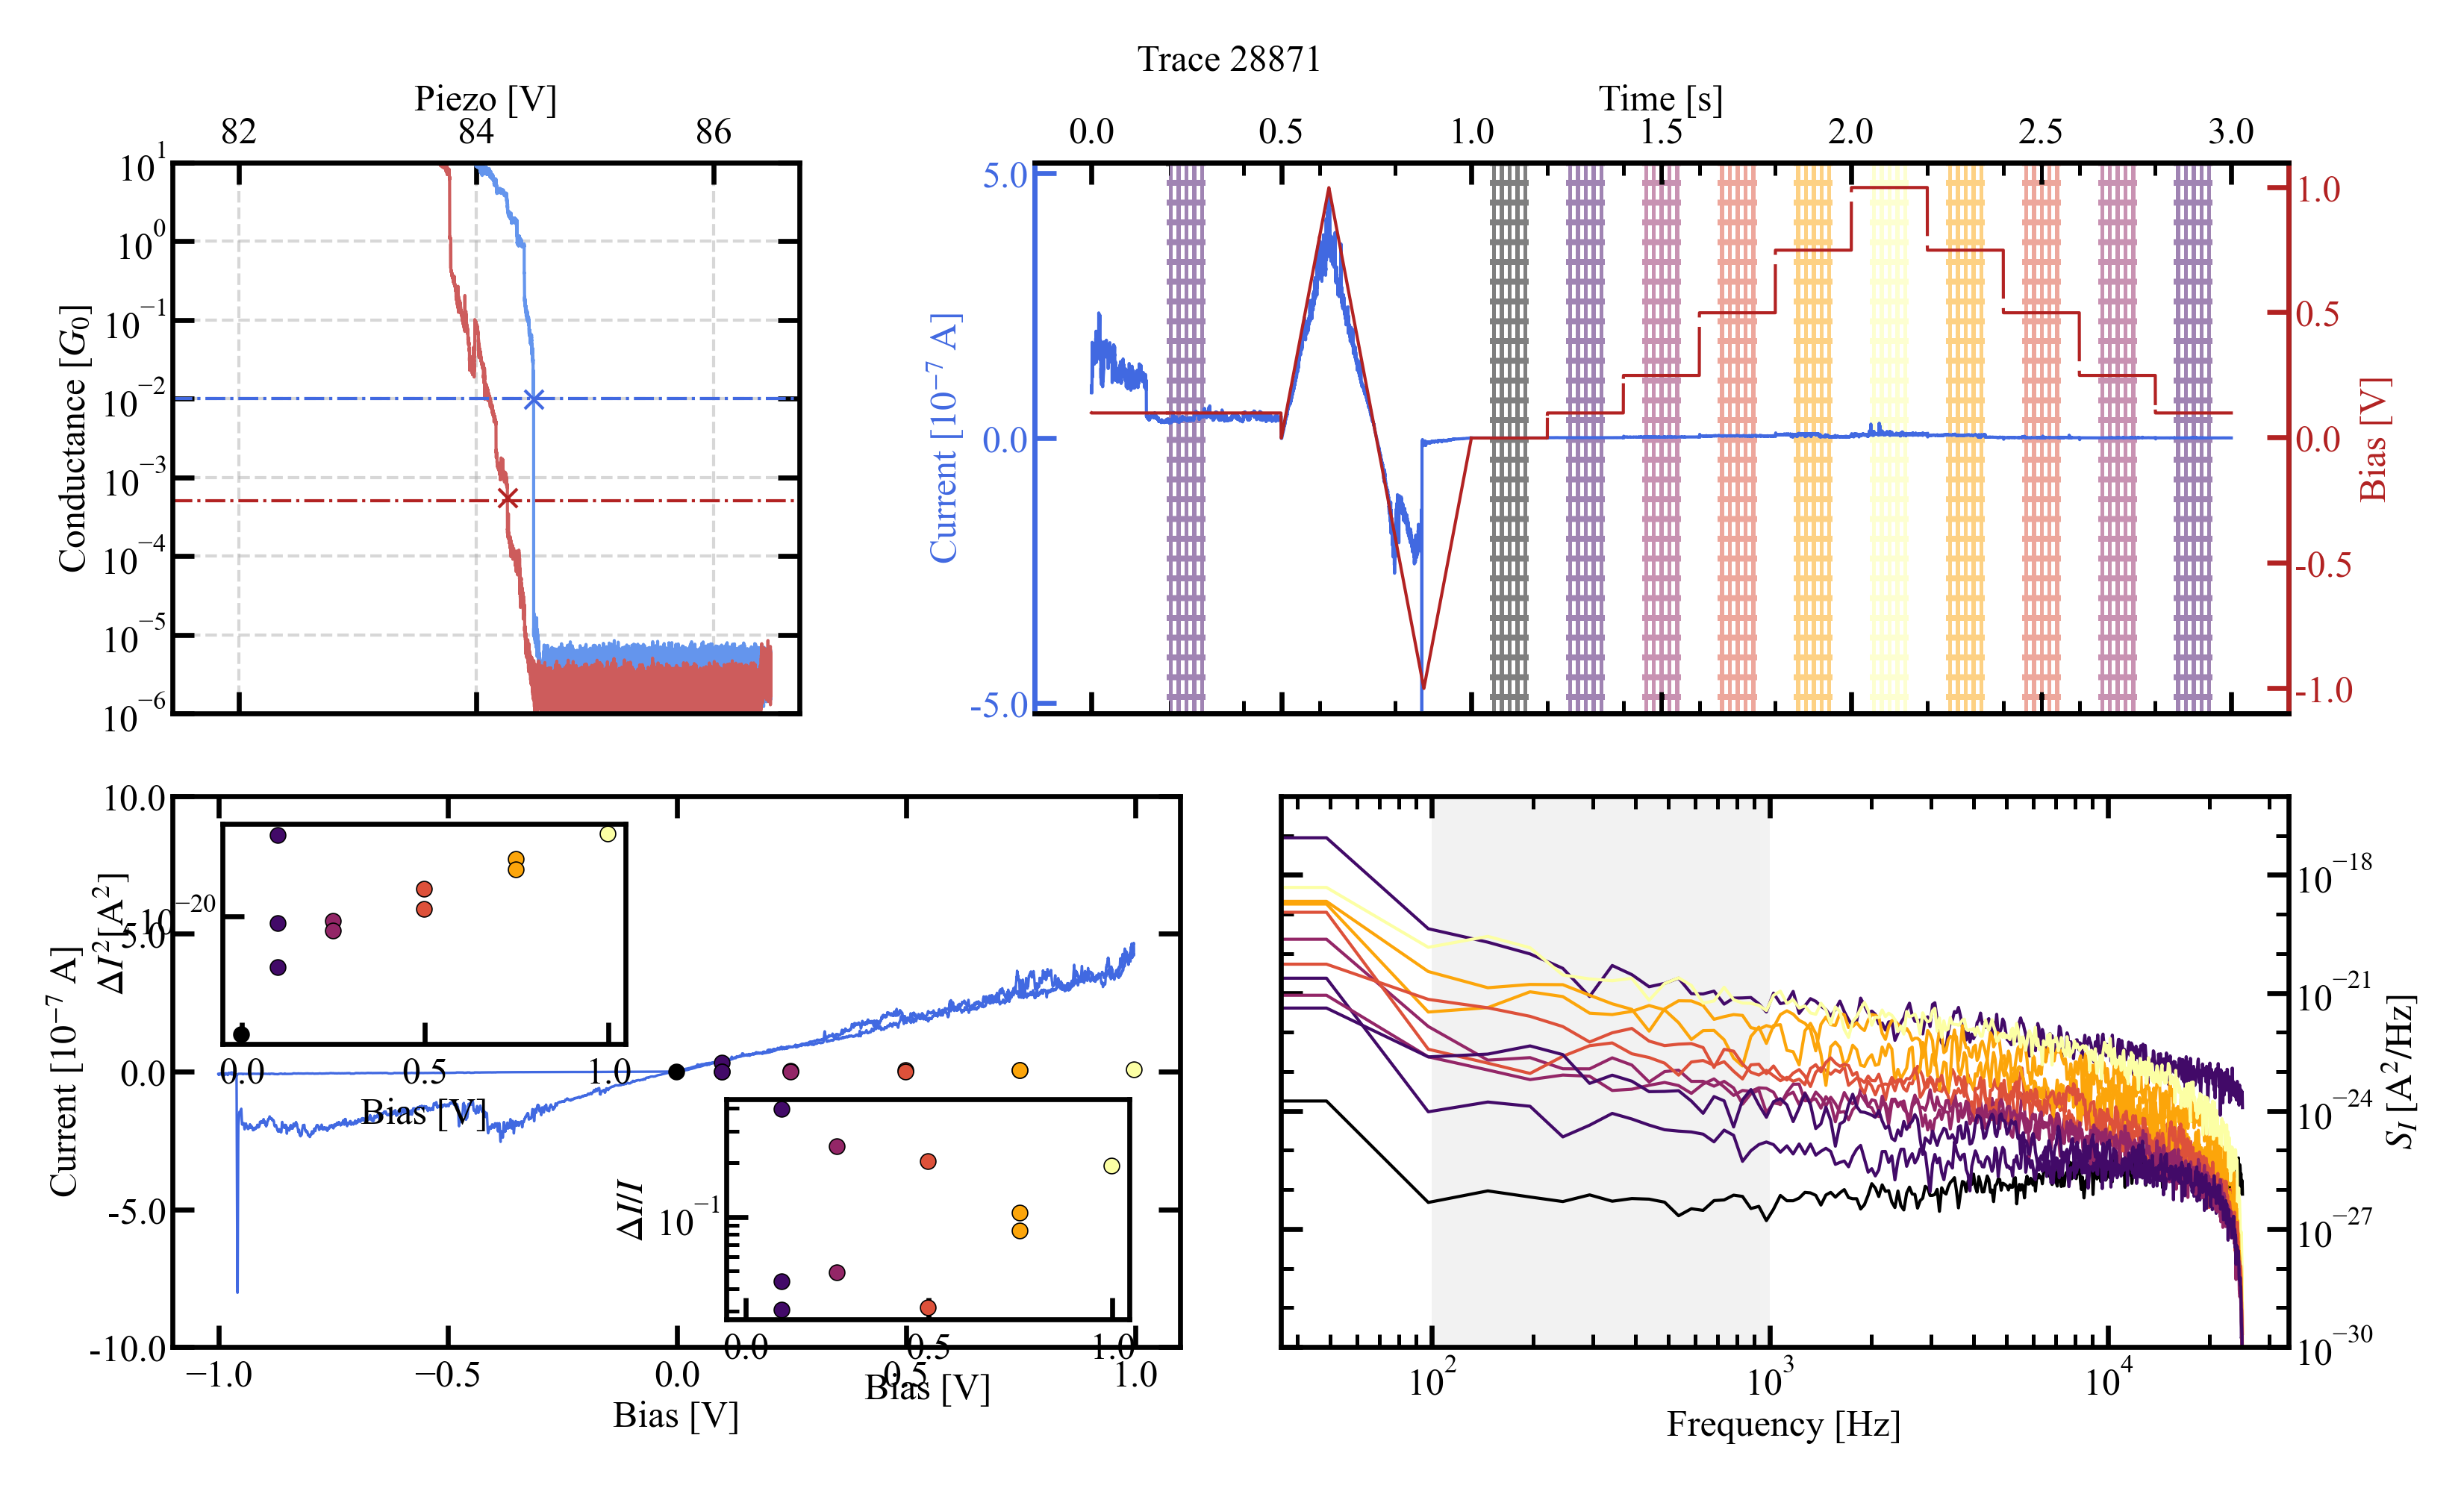

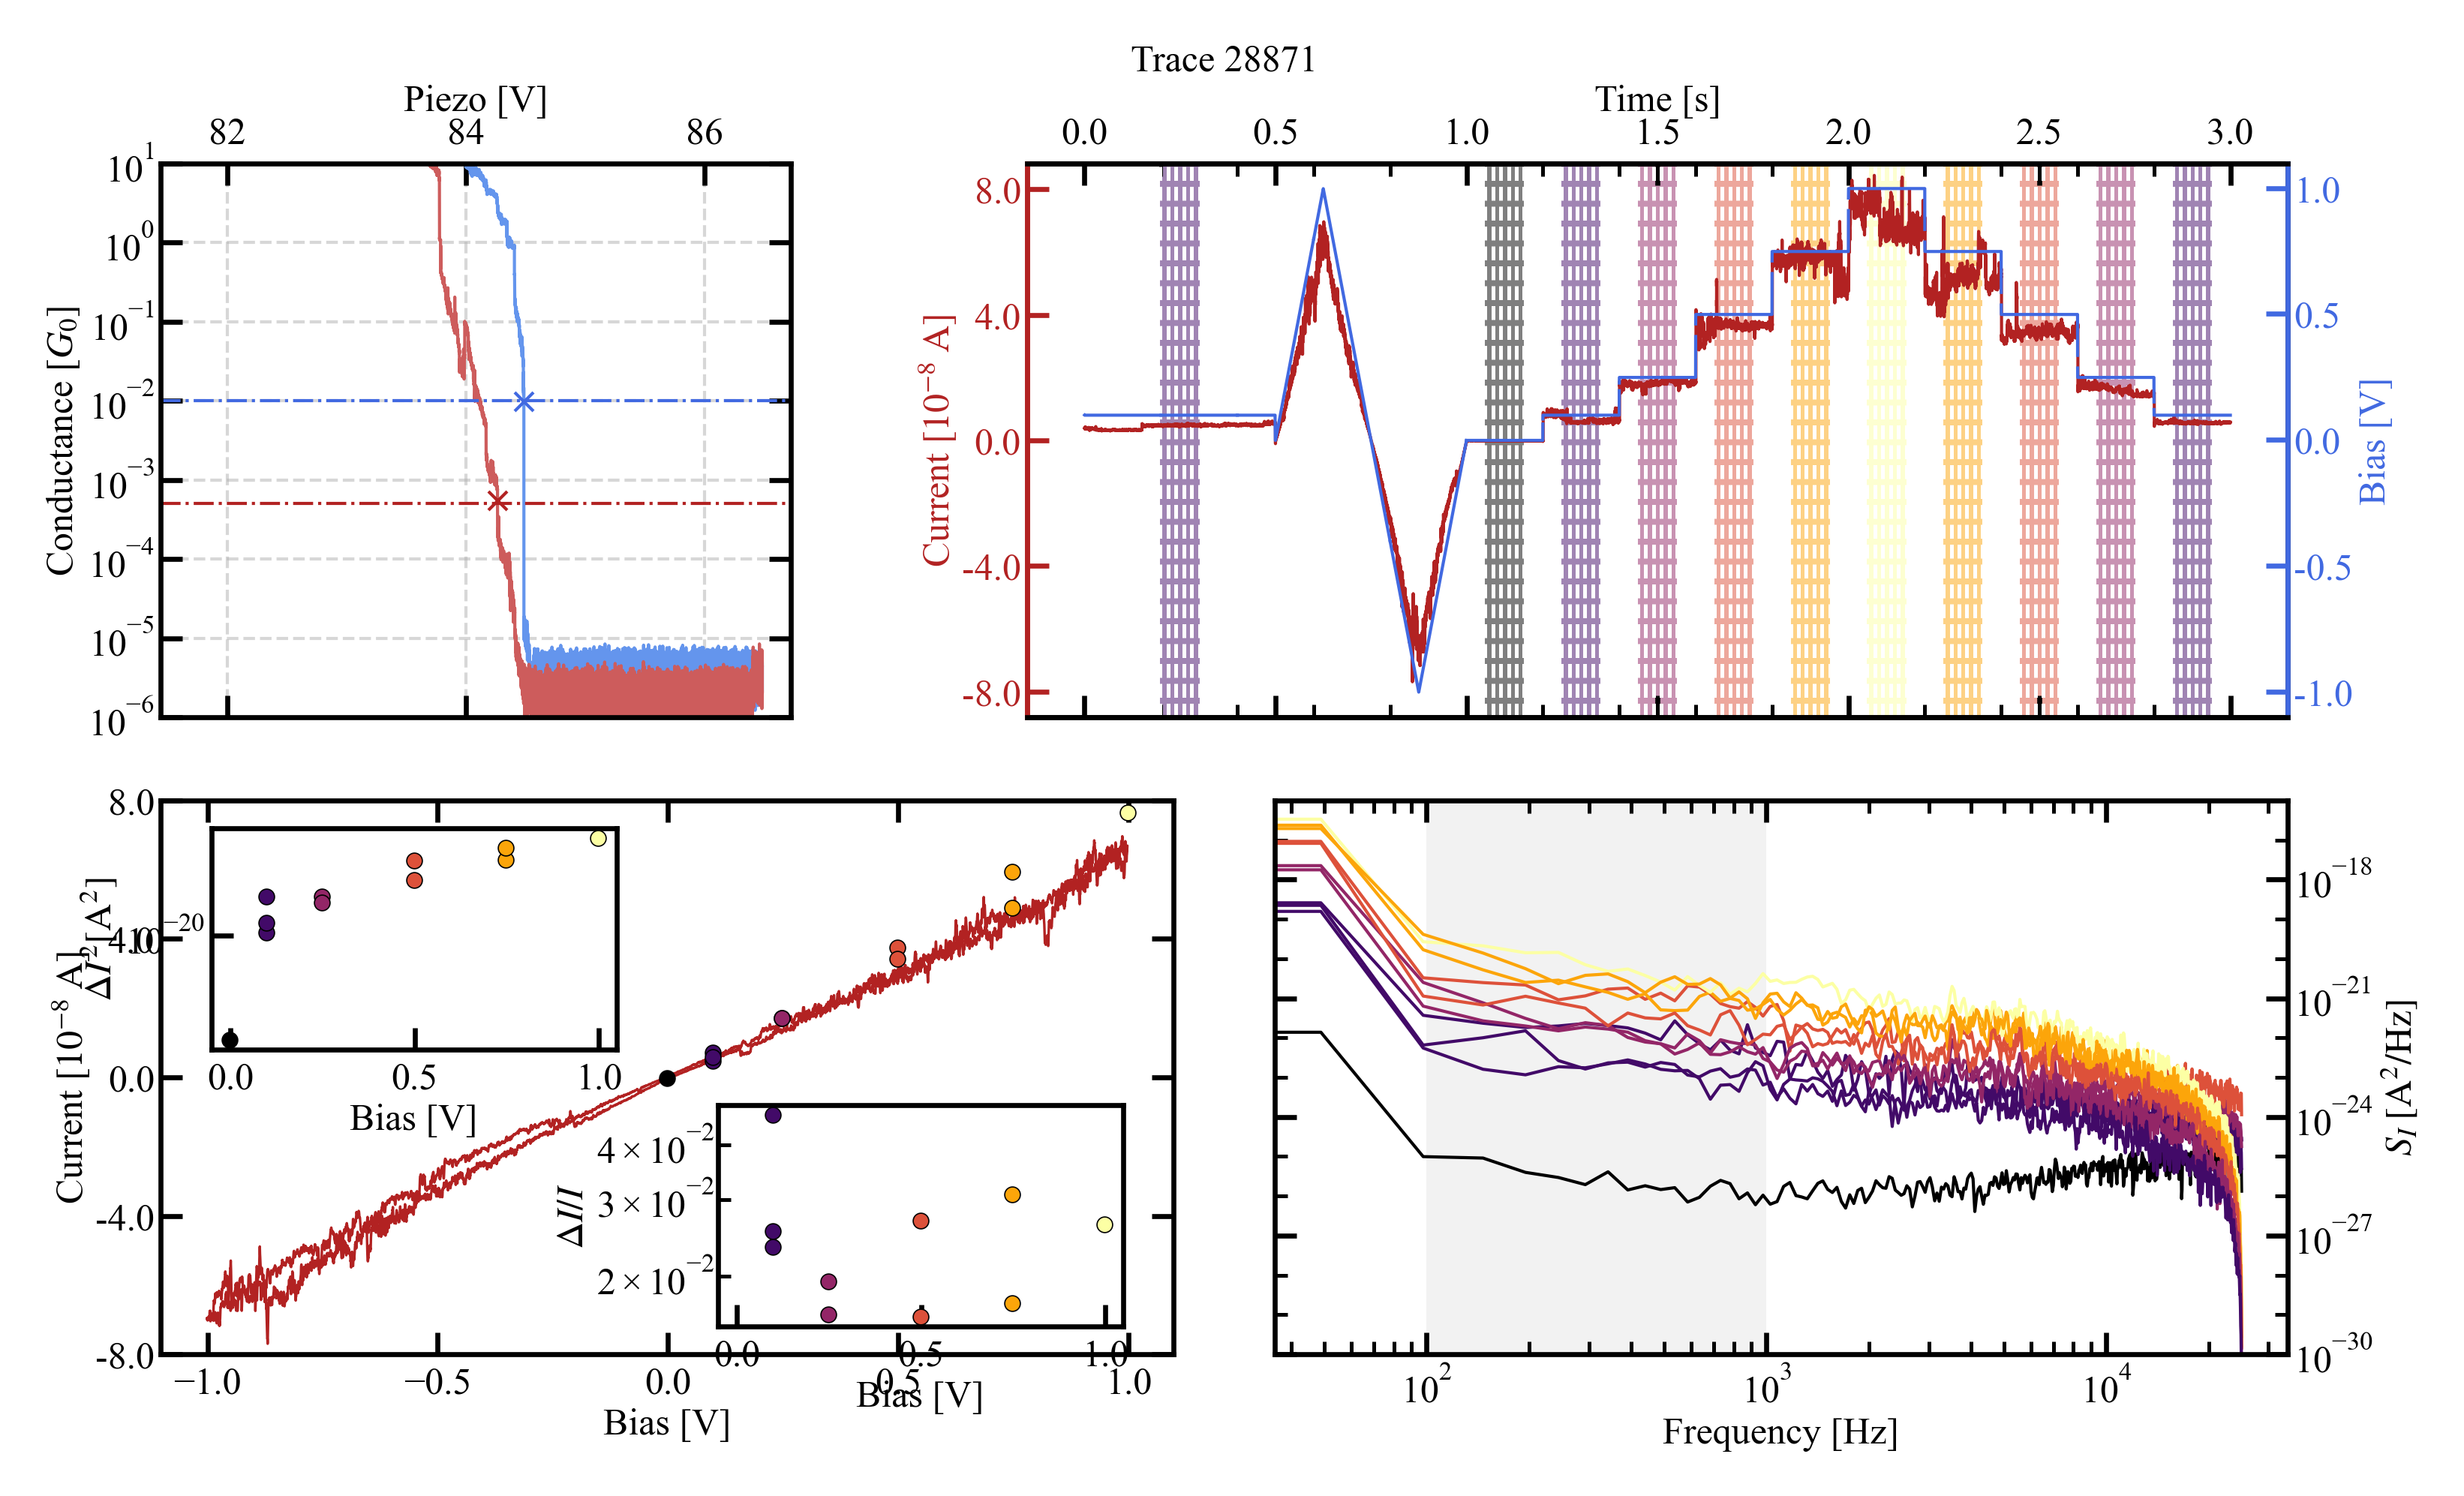

In [31]:
# which_trace = iv_good_pull[np.argsort(filtered_pull_diff)][count]
which_trace = 28871
# for which_trace in tqdm(iv_good_pull[np.argsort(filtered_pull_diff)]):

hold_trace = HoldTrace(which_trace,
                       load_from=home_folder, bias_offset=0,
                       r_serial_ohm=100300, min_step_len=5_000, min_height=1, iv=0)

trace_pair = TracePair(which_trace, load_from=home_folder)

hold_trace.analyse_hold_trace(num_of_fft=5, subtract_bg=False)

# print(hold_trace.bias_steps.shape)

fig_pull, ax_trace_pull, ax_hold_pull, par_hold_pull, ax_iv_pull, ax_psd_pull = \
    plots.plot_ivs_scheme_one(trace_pair=trace_pair, hold_trace=hold_trace, direction='pull', color_list=my_colors, vline_color='white',
                              smoothing=10, which_psds=None)

ax_hold_pull.set_ylim(-1*max(hold_trace.hold_current_pull), max(hold_trace.hold_current_pull))

ax_noise_pull_1 = ax_iv_pull.inset_axes(bounds=(0.05, 0.55, 0.4, 0.4))
ax_noise_pull_2 = ax_iv_pull.inset_axes(bounds=(0.55, 0.05, 0.4, 0.4))

for i in range(len(my_colors)):
    ax_iv_pull.plot(hold_trace.bias_steps[i], hold_trace.avg_current_on_step_pull[i], marker='o', ls='', ms=2.5, markeredgecolor='k', markeredgewidth=0.2, c=my_colors[i])
    ax_noise_pull_1.plot(hold_trace.bias_steps[i], hold_trace.areas_pull[i], marker='o', ls='', ms=2.5, markeredgecolor='k', markeredgewidth=0.2, c=my_colors[i])
    ax_noise_pull_2.plot(hold_trace.bias_steps[i], hold_trace.current_noise_pull[i], marker='o', ls='', ms=2.5, markeredgecolor='k', markeredgewidth=0.2, c=my_colors[i])

ax_noise_pull_1.set_xlabel('Bias [V]')
ax_noise_pull_2.set_xlabel('Bias [V]')

ax_noise_pull_1.set_ylabel(r'$\Delta I^2 [\mathrm{A}^2]$')
ax_noise_pull_2.set_ylabel(r'$\Delta I/I$')

ax_noise_pull_1.set_yscale('log')
ax_noise_pull_2.set_yscale('log')

fig_pull.suptitle(f'Trace {which_trace}', fontsize=6)

fig_push, ax_trace_push, ax_hold_push, par_hold_push, ax_iv_push, ax_psd_push = \
    plots.plot_ivs_scheme_one(trace_pair=trace_pair, hold_trace=hold_trace, direction='push', color_list=my_colors, vline_color='white',
                              smoothing=10, which_psds=None)

ax_hold_push.set_ylim(-1*max(hold_trace.hold_current_push), max(hold_trace.hold_current_push))

ax_noise_push_1 = ax_iv_push.inset_axes(bounds=(0.05, 0.55, 0.4, 0.4))
ax_noise_push_2 = ax_iv_push.inset_axes(bounds=(0.55, 0.05, 0.4, 0.4))

for i in range(len(my_colors)):
    ax_iv_push.plot(hold_trace.bias_steps[i], hold_trace.avg_current_on_step_push[i], marker='o', ls='', ms=2.5, markeredgecolor='k', markeredgewidth=0.2, c=my_colors[i])
    ax_noise_push_1.plot(hold_trace.bias_steps[i], hold_trace.areas_push[i], marker='o', ls='', ms=2.5, markeredgecolor='k', markeredgewidth=0.2, c=my_colors[i])
    ax_noise_push_2.plot(hold_trace.bias_steps[i], hold_trace.current_noise_push[i], marker='o', ls='', ms=2.5, markeredgecolor='k', markeredgewidth=0.2, c=my_colors[i])

ax_noise_push_1.set_xlabel('Bias [V]')
ax_noise_push_2.set_xlabel('Bias [V]')

ax_noise_push_1.set_ylabel(r'$\Delta I^2 [\mathrm{A}^2]$')
ax_noise_push_2.set_ylabel(r'$\Delta I/I$')

ax_noise_push_1.set_yscale('log')
ax_noise_push_2.set_yscale('log')

fig_push.suptitle(f'Trace {which_trace}', fontsize=6)
# plt.savefig(home_folder.joinpath(f'results/figs/pull_{which_trace}.png'), bbox_inches='tight')
# plt.close()

# print(filter_traces.iv_difference(hold_trace, direction='pull', smoothing=100))